# AI Tools for Actuaries
## Chapter 5: CANN approach in Python
### Author: Marco Maggi, Michael Mayer and Mario Wuthrich
### Version May 2025

In [1]:
# Import required libraries
import pandas as pd
import torch
import numpy as np
from statsmodels.formula.api import glm
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(500)
# See all pandas columns
pd.set_option("display.max_columns", None)

### Load data

In [2]:
# Load the data
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678007 non-null  float64 
 1   Exposure    678007 non-null  float64 
 2   Area        678007 non-null  category
 3   VehPower    678007 non-null  int32   
 4   VehAge      678007 non-null  int32   
 5   DrivAge     678007 non-null  int32   
 6   BonusMalus  678007 non-null  int32   
 7   VehBrand    678007 non-null  category
 8   VehGas      678007 non-null  category
 9   Density     678007 non-null  int32   
 10  Region      678007 non-null  category
 11  ClaimTotal  678007 non-null  float64 
 12  ClaimNb     678007 non-null  float64 
 13  LearnTest   678007 non-null  object  
dtypes: category(4), float64(4), int32(5), object(1)
memory usage: 41.4+ MB
None


,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


### Pre-process data for GLM

In [4]:
# Create GLM features
driv_age_lev = ["18-20", "21-25", "26-30", "31-40", "41-50", "51-70", "71+"]
driv_age_lev2 = ["31-40", *[lev for lev in driv_age_lev if lev != "31-40"]]

df = df.assign(
    AreaGLM=lambda x: x.Area.cat.codes + 1,  # Make Area code continuous
    VehPowerGLM=lambda x: pd.Categorical(x.VehPower.clip(0, 9)),  # Make categorical
    # Create age categories
    VehAgeGLM=lambda x: pd.cut(
        x.VehAge, bins=[-1, 5, 12, 101], labels=["0-5", "6-12", "12+"]
    ),
    DrivAgeGLM=lambda x: pd.Categorical(
        pd.cut(x.DrivAge, bins=[17, 20, 25, 30, 40, 50, 70, 101], labels=driv_age_lev),
        categories=driv_age_lev2,
    ),
    BonusMalusGLM=lambda x: x.BonusMalus.clip(0, 150),  # Censor bonus-malus level
    DensityGLM=lambda x: np.log(x.Density),  # Log-transform density
)

df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L,4,6,6-12,18-20,100,6.263398
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L,5,6,6-12,26-30,59,7.823246
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L,3,7,6-12,26-30,68,4.812184
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L,4,4,12+,31-40,50,7.011214
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L,1,5,12+,41-50,50,3.526361


### Split into learning sample and test sample

In [5]:
# Split data (this uses the same split and order as in Wuthrich-Merz, Springer 2023)
learn, test = (df[df.LearnTest == subset].copy() for subset in ("L", "T"))

print(f"Learning set size: {learn.shape[0]}")
print(f"Test set size: {test.shape[0]}")

Learning set size: 610206
Test set size: 67801


## GLM analysis

In [6]:
# Fit GLM
model = glm(
    "ClaimNb ~ DrivAgeGLM + VehBrand + VehGas + DensityGLM + AreaGLM",
    data=learn,
    offset=np.log(learn["Exposure"]),
    family=sm.families.Poisson(),
)

glm_results = model.fit()

# Display model summary
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610206
Model:                            GLM   Df Residuals:                   610186
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -98513.
Date:                Fri, 23 May 2025   Deviance:                   1.5138e+05
Time:                        08:38:34   Pearson chi2:                 1.02e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004052
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.2590    

### Calculate deviance losses

In [7]:
from sklearn.metrics import mean_poisson_deviance

# Get predictions
learn["GLM"] = glm_results.predict(learn) * learn["Exposure"]
test["GLM"] = glm_results.predict(test) * test["Exposure"]

# Calculate in-sample and out-of-sample deviance
learn_deviance, test_deviance = (
    100
    * mean_poisson_deviance(
        x.ClaimNb / x.Exposure, x.GLM / x.Exposure, sample_weight=x.Exposure
    )
    for x in (learn, test)
)

print("Deviance Losses:")
print(f"Learning sample: {learn_deviance:.3f}")
print(f"Test sample: {test_deviance:.3f}")

Deviance Losses:
Learning sample: 46.954
Test sample: 47.179


## CANN step: using the GLM predictors as offsets in the FNN

### Pre-process data for FNN - using entity embedding
### Define the Scikit-Learn preprocessor

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler,
)


def clip_and_scale(upper):
    pipe = Pipeline(
        steps=[
            ("clip", FunctionTransformer(lambda x: np.clip(x, a_min=0, a_max=upper))),
            ("scale", StandardScaler()),
        ]
    )
    return pipe


density = Pipeline(
    steps=[
        ("log", FunctionTransformer(lambda x: np.log(x).round(2))),
        ("scale", StandardScaler()),
    ]
)

area = Pipeline(
    steps=[
        ("encode", OrdinalEncoder()),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        ("area", area, ["Area"]),
        ("density", density, ["Density"]),
        (
            "veh_gas",
            FunctionTransformer(lambda x: (x == "Diesel").astype(np.float32)),
            ["VehGas"],
        ),
        ("veh_brand", OrdinalEncoder(), ["VehBrand", "Region"]),
    ],
    verbose_feature_names_out=False,
)

# Just a check: Fit preprocessor to training data and apply to some lines from test
preprocessor.set_output(transform="pandas").fit(learn)
preprocessor.transform(test.head())

,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehGas,VehBrand,Region
610206,-1.29173,-1.309026,1.937902,-1.196789,0.513423,0.298236,0.0,3.0,14.0
610207,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,0.0,3.0,0.0
610208,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,0.0,3.0,0.0
610209,-1.29173,1.663510,-0.497176,-0.709264,0.513423,0.666918,0.0,3.0,0.0
610210,-1.29173,0.460341,-0.625338,-0.709264,-0.209473,-0.476529,0.0,3.0,20.0


### Split in covariates X, responses y, GLM prior for CANN step


In [9]:
from sklearn.model_selection import train_test_split

convert_to_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
train, val = train_test_split(learn, test_size=0.1, random_state=125548)

X_learn = convert_to_tensor(preprocessor.fit_transform(learn))
X_train = convert_to_tensor(preprocessor.transform(train))
X_val = convert_to_tensor(preprocessor.transform(val))
X_test = convert_to_tensor(preprocessor.transform(test))

y_learn, v_learn = convert_to_tensor(learn.ClaimNb), convert_to_tensor(learn.GLM)
y_train, v_train = convert_to_tensor(train.ClaimNb), convert_to_tensor(train.GLM)
y_val, v_val = convert_to_tensor(val.ClaimNb), convert_to_tensor(val.GLM)
y_test, v_test = convert_to_tensor(test.ClaimNb), convert_to_tensor(test.GLM)

### Define FNN of depth 3 with entity embeddings for categorical variables

In [10]:
from torch import nn
from torch.nn import init


class FNN(nn.Module):
    def __init__(self, seed, n_features, hidden_layers, kk, bb):
        super().__init__()
        torch.manual_seed(seed)
        self.hidden_layers = nn.ModuleList()
        self.brand_embed = nn.Embedding(kk[0], bb[0])
        self.region_embed = nn.Embedding(kk[1], bb[1])
        embed_dim = bb[0] + bb[1]
        for i in range(len(hidden_layers)):
            if i == 0:
                self.hidden_layers.append(
                    nn.Linear(n_features - 2 + embed_dim, hidden_layers[i])
                )
            else:
                self.hidden_layers.append(
                    nn.Linear(hidden_layers[i - 1], hidden_layers[i])
                )
        self.output_layer = nn.Linear(hidden_layers[-1], 1)
        init.constant_(self.output_layer.weight, 0.0)
        init.constant_(self.output_layer.bias, 0.0)

    def forward(self, x, v):
        embedded_brand = self.brand_embed(x[:, -2].long())
        embedded_region = self.region_embed(x[:, -1].long())
        continuous_features = x[:, :-2]
        x = torch.cat((continuous_features, embedded_brand, embedded_region), dim=1)
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        return torch.exp(self.output_layer(x)).flatten() * v


SEED = 21456783
M_FEAT = X_train.shape[1]  # number of features
HIDDEN = [20, 15, 10]
KK = [len(learn.VehBrand.unique()), len(learn.Region.unique())]  # number of categories
BB = [2, 2]  # embedding dimensions for brand and region
# Create model with three hidden layers
model = FNN(SEED, n_features=M_FEAT, hidden_layers=HIDDEN, kk=KK, bb=BB)

### Replicate GLM results within the FNN architecture

In [11]:
from sklearn.metrics import mean_poisson_deviance


def score(model, X, y, v, w):
    """Evaluate the model using sklearn's mean_poisson_deviance."""
    pred = model(X, v).detach().numpy()
    return 100 * mean_poisson_deviance(
        y.detach().numpy() / w, pred / w, sample_weight=w
    )


print(
    f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn, learn.Exposure):.3f}"
)
print(
    f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test, test.Exposure):.3f}"
)

Poisson Deviance (Learn): 46.954
Poisson Deviance (Test): 47.179


### Train the CANN model

In [12]:
def train_model(
    model,
    X_train,
    y_train,
    v_train,
    w_train,
    X_val,
    y_val,
    v_val,
    w_val,
    optimizer,
    checkpoint_path,
    batch_size,
    n_epochs=100,
):
    loss_fn = nn.PoissonNLLLoss(log_input=False, reduction="sum")
    best_val_loss = float("inf")
    history = {"loss": [], "val_loss": []}

    # Create dataset indices for batching
    num_batches = (len(X_train) + batch_size - 1) // batch_size

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        # indices can be shuffled for each epoch. We don't do it here.
        indices = torch.arange(len(X_train))

        for i in range(num_batches):
            # Get batch indices
            batch_indices = indices[
                i * batch_size : min((i + 1) * batch_size, len(X_train))
            ]

            # Get batch data
            X_batch = X_train[batch_indices]
            v_batch = v_train[batch_indices]
            y_batch = y_train[batch_indices]

            # Forward pass
            pred_batch = model(X_batch, v_batch)
            loss = loss_fn(pred_batch, y_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average loss for the epoch
        epoch_loss /= w_train.sum()
        history["loss"].append(epoch_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val, v_val)
            val_loss = loss_fn(pred_val, y_val).item() / w_val.sum()
            history["val_loss"].append(val_loss)

        # Save best model
        if val_loss < best_val_loss and isinstance(checkpoint_path, str):
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}"
            )
    return history

In [13]:
optimizer = torch.optim.NAdam(model.parameters())
checkpoint_path = f"./Networks/CANN_{SEED}.pt"
history = train_model(
    model,
    X_train,
    y_train,
    v_train,
    train.Exposure,
    X_val,
    y_val,
    v_val,
    val.Exposure,
    optimizer,
    checkpoint_path,
    batch_size=5_000,
    n_epochs=200,
)

Epoch 10/200, Loss: 0.2940, Val Loss: 0.2945
Epoch 20/200, Loss: 0.2934, Val Loss: 0.2941
Epoch 30/200, Loss: 0.2931, Val Loss: 0.2940
Epoch 40/200, Loss: 0.2929, Val Loss: 0.2940
Epoch 50/200, Loss: 0.2927, Val Loss: 0.2940
Epoch 60/200, Loss: 0.2926, Val Loss: 0.2941
Epoch 70/200, Loss: 0.2924, Val Loss: 0.2943
Epoch 80/200, Loss: 0.2923, Val Loss: 0.2944
Epoch 90/200, Loss: 0.2922, Val Loss: 0.2945
Epoch 100/200, Loss: 0.2921, Val Loss: 0.2946
Epoch 110/200, Loss: 0.2919, Val Loss: 0.2946
Epoch 120/200, Loss: 0.2918, Val Loss: 0.2946
Epoch 130/200, Loss: 0.2916, Val Loss: 0.2946
Epoch 140/200, Loss: 0.2914, Val Loss: 0.2945
Epoch 150/200, Loss: 0.2913, Val Loss: 0.2945
Epoch 160/200, Loss: 0.2912, Val Loss: 0.2946
Epoch 170/200, Loss: 0.2911, Val Loss: 0.2946
Epoch 180/200, Loss: 0.2910, Val Loss: 0.2947
Epoch 190/200, Loss: 0.2909, Val Loss: 0.2948
Epoch 200/200, Loss: 0.2909, Val Loss: 0.2948


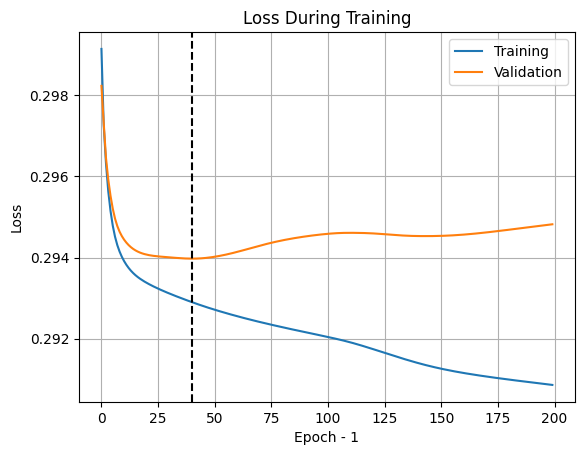

In [14]:
# Plot training history (vertical line at best validation loss)
fig = (
    pd.DataFrame({"loss": history["loss"], "val_loss": history["val_loss"]})
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(np.argmin(history["val_loss"]), color="black", linestyle="--")


### CANN results

In [15]:
# Load best weights and evaluate
model.load_state_dict(torch.load(checkpoint_path))

print(
    "Poisson Deviance GLM (Learn-Test):",
    round(learn_deviance, 3),
    round(test_deviance, 3),
)

print(
    f"Poisson Deviance CANN (Learn-Test): {score(model, X_learn, y_learn, v_learn, learn.Exposure):.3f}, {score(model, X_test, y_test, v_test, test.Exposure):.3f}"
)

Poisson Deviance GLM (Learn-Test): 46.954 47.179
Poisson Deviance CANN (Learn-Test): 44.989, 44.976


### Plot the marginalized expected frequency for the Driver Age input variable

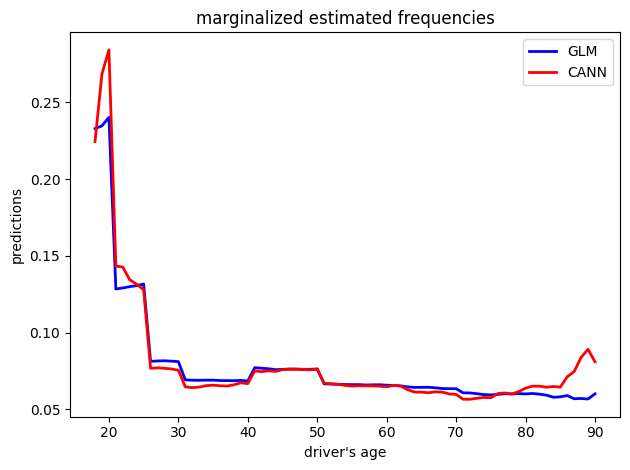

In [16]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    learn["CANN"] = model(X_learn, v_learn).detach().numpy()
    test["CANN"] = model(X_test, v_test).detach().numpy()

# Create figure
# Calculate aggregated frequencies
learn["DrivAgeX"] = learn["DrivAge"].clip(upper=90)
aggr = (
    learn.groupby("DrivAgeX")
    .agg({"GLM": "sum", "CANN": "sum", "Exposure": "sum"})
    .reset_index()
)


aggr["GLM"] = aggr["GLM"] / aggr["Exposure"]
aggr["CANN"] = aggr["CANN"] / aggr["Exposure"]

# Plot marginalized estimated frequencies
plt.plot(aggr["DrivAgeX"], aggr["GLM"], "blue", linewidth=2, label="GLM")
plt.plot(aggr["DrivAgeX"], aggr["CANN"], "red", linewidth=2, label="CANN")
plt.xlabel("driver's age")
plt.ylabel("predictions")
plt.title("marginalized estimated frequencies")
plt.legend()

plt.tight_layout()
plt.show()